# Neural Style Transfer

dated: 31 Jan 2023

Barone Francesco

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

In [2]:
torch.manual_seed(17)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# I/O -----------------------------

#STYLE_IMAGE_FILE = "./image/vangogh.jpg"
STYLE_IMAGE_FILE = "./image/picasso.jpg"
#STYLE_IMAGE_FILE = "./image/the_scream.jpg"

#CONTENT_IMAGE_FILE = "./image/tuebingen.jpg"
CONTENT_IMAGE_FILE = "./image/golden_gate.jpg"
#CONTENT_IMAGE_FILE = "./image/dancing.jpg"

## model definition

In [5]:
class nst_network(nn.Module):
    """Network for Neural Style Transfer, built on top of a nst19 to return specific layer features."""

    def __init__(self, input_model, forward_hooks:list,
                 pool:str = 'max',  crop_model:bool = True
                ):
        super().__init__()

        # -----------------------------
        #       HOOKS MANAGEMENT
        # -----------------------------
        self.hooks, self.hook_handlers = {}, []
        def takeOutput(name:str):
            def hook(model, input, output):
                self.hooks[name] = output #.detach()
                # note: DO NOT DETACH! I WILL NEED GRADIENTS LATER
            return hook
        #
        #  self.hook_handlers     will store the handlers of
        #                         fwd hooks I will register
        #  self.hooks             will store the values taken with hooks
        #                         from selected layers

        self.hooks_init = forward_hooks.copy()  # keep a backup copy of this arg
        todo_hooks = set(forward_hooks)         # will use this list while I loop on network layers


        # --------------------------------------
        #              MODEL BUILD
        # --------------------------------------
        #   I loop over the input model layers,
        #  registering a hook when requested.
        # --------------------------------------
        self.model = nn.Sequential()
        
        conv_num, conv_group = 1, 1
        for layer in input_model.children():
            
            if isinstance(layer, nn.Conv2d):
                name = 'conv{}_{}'.format(conv_group, conv_num)
            
            elif isinstance(layer, nn.ReLU):
                name = 'relu{}_{}'.format(conv_group, conv_num)
                #  ^^  takes the name similar to last conv layer
                conv_num += 1

            elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d) ):
                # take name & reset counters
                name = 'pool_{}'.format(conv_group)
                conv_group += 1;   conv_num = 1; 

                # replace pool layer with desired choice
                if   pool.lower() == 'avg':
                    layer = nn.AvgPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                elif pool.lower() == 'max':
                    layer = nn.MaxPool2d( kernel_size = layer.kernel_size,
                                          stride = layer.stride )
                else:
                    raise RuntimeError('not valid pool arg ({})'.format(pool))

            else: name = 'buh'
            
            self.model.add_module(name, layer)

            if name in todo_hooks:
                # register a hook for current layer and track its handler
                self.hook_handlers.append(
                    self.model[-1].register_forward_hook( takeOutput(name) )
                )
                todo_hooks.remove(name)

            if crop_model:
                if not todo_hooks: break
        
        # fix the weights, to be sure
        for param in self.model.parameters():
            param.requires_grad = False

        # set to eval mode
        self.model.eval()


    def forward(self, x, query : list = None):

        self.hooks = {}     # reset hooks dict

        _ = self.model(x)   # I don't care about this ...

        # ... returns the features extracted by hooks
        if query is not None:
            return [ self.hooks[key] for key in query ]
            # this is a list
        else:
            return self.hooks
            # this is a dict

### allocate the network

To do this I need the list of layer to hook from.

In [6]:
#content_layers = ['relu4_2']
#style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

**Ref**: VGG19 doc
https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html

> Accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects.

In [7]:
# take the original nst model (pretrained weights)
vgg19 = torchvision.models.vgg19(weights='IMAGENET1K_V1')

# according to VGG199 documentation, the network uses these
# parameters for input normalization
vgg19_mean = np.array( [0.485, 0.456, 0.406] )
vgg19_std = np.array( [0.229, 0.224, 0.225] )

nstn = nst_network(vgg19.features, content_layers + style_layers)
nstn.to(device);   # to suppress network layout print

## Loss functions

In [8]:
# gram matrix
def gramfn( xx : torch.Tensor , use_batch : bool = True):
    if use_batch:  batch, ch, H, W = xx.size()
    else:
        ch, H, W = xx.size()
        batch = 1
    view = xx.view(batch, ch, H*W)
    gram = torch.matmul(view, view.transpose(1,2))
    gram.div_(H*W)
    return gram

# I wrap it to look like a loss function from pytorch
class GramLoss( nn.Module ):
    def forward(self, input, target):
        # note: target should not require gradient!
        #       and must be a gram matrix
        return nn.MSELoss()( gramfn(input), target )

## Image processing

In [9]:
# pre and post processing for images
img_size = 512

img_preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = vgg19_mean, std=vgg19_std),
        transforms.Lambda(lambda x: x.mul_(255)),
])

img_revert = transforms.Compose([
        transforms.Lambda(lambda x: x.mul_(1./255)),
        transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/vgg19_std),
        transforms.Normalize(mean = -vgg19_mean, std = [1,1,1]),
])

transf_toPIL = transforms.Compose([ transforms.ToPILImage() ])

def tens2pil( img_tensor ):
    img_tensor = img_tensor.clone().detach()
    # invert the input trasform
    x = img_revert(img_tensor)
    # removed burned areas
    t = torch.clamp( x, min=0, max=1)
    return transf_toPIL( torch.squeeze(t) )

In [10]:
def load_image(filename, preprocess = None, device = None, add_batch : bool = True):
    img = Image.open(filename)

    # optional: apply custom preprocess function, else use the default
    if preprocess: img = preprocess(img)
    else:          img = img_preprocess(img)

    # optional: send to device
    if device:     img = img.to(device)

    # optional: add dummy batch dimention
    if add_batch:  img = img.unsqueeze(0)
    
    return img


style_image = load_image(STYLE_IMAGE_FILE, device = device)
content_image = load_image(CONTENT_IMAGE_FILE, device = device)

generated_img = torch.autograd.Variable(content_image.clone(), requires_grad=True)

### compute target features

In [11]:
class catLoss():
    """This class collects all the useful stuff to compute & track the losses"""
    def __init__(self, layers : list, targets : list,
                 lossfn = lambda x: x,   # loss function to call for all values in this collection
                 #fn = lambda x: x,       # function to process input when computing loss
                 weights : list = None,  # if provided, will use the given weights
                 scale : float = 1.0     # general weight scale factor 
                ):
        assert len(targets) == len(layers)

        n = len(layers)

        self.layers = layers
        self.targets = targets
        self.lossfn = lossfn

        if weights is None:
            self.weights = [ 1/n ]*n
        else:
            assert len(weights) == n
            self.weights = weights

        self.hist = []
        self.scale = scale

    def compute_loss(self, feats : list):
        tmp = self.scale*sum([ self.weights[ii]*self.lossfn(ft, self.targets[ii]) for ii, ft in enumerate(feats) ])

        self.hist.append( tmp.item() )
        return tmp
    
    def compute_loss_from_dict(self, feats : dict):
        feats = [ feats[key] for key in self.layers ]
        
        tmp = self.scale*sum([ self.weights[ii]*self.lossfn(ft, self.targets[ii]) for ii, ft in enumerate(feats) ])
        self.hist.append( tmp.item() )
        return tmp

In [12]:
def compute_feat( model, image, layers, fn = lambda x : x) -> list:
    return [ fn(x).detach().to(device) for x in model(image, layers) ]

target_style_feat = compute_feat(nstn, style_image, style_layers, gramfn)
target_content_feat = compute_feat(nstn, content_image, content_layers)

## NST in action

In [13]:
catStyle   = catLoss(style_layers, target_style_feat, GramLoss(), weights = [ 1e2/n**2 for n in [64,128,256,512,512] ] )
# ^ weights = [ 1e2/n**2 for n in [64,128,256,512,512] ]
# v scale = 1e0
catContent = catLoss(content_layers, target_content_feat, nn.MSELoss(), scale = 1e-2 )  #reduction='sum'

iter_max = 500

optimizer = torch.optim.LBFGS([generated_img])

In [14]:
# run style transfer

iter_count = 0
def closure() -> torch.Tensor:
    global iter_count

    optimizer.zero_grad()
    
    feats = nstn( generated_img )

    loss_style = catStyle.compute_loss_from_dict( feats )
    loss_cont = catContent.compute_loss_from_dict( feats )
    loss = loss_style + loss_cont

    loss.backward()
    
    if iter_count%tqdm_update == 0:
        pbar.update(tqdm_update)
        pbar.set_postfix_str("loss = {}".format( loss.item() ) )
    iter_count += 1
    return loss
    

with tqdm(total=iter_max, desc='Neural Style transfer') as pbar:
    tqdm_update = 20
    while iter_count <= iter_max:
        optimizer.step(closure)

Neural Style transfer: 520it [00:36, 14.26it/s, loss = 8141.40087890625]                         


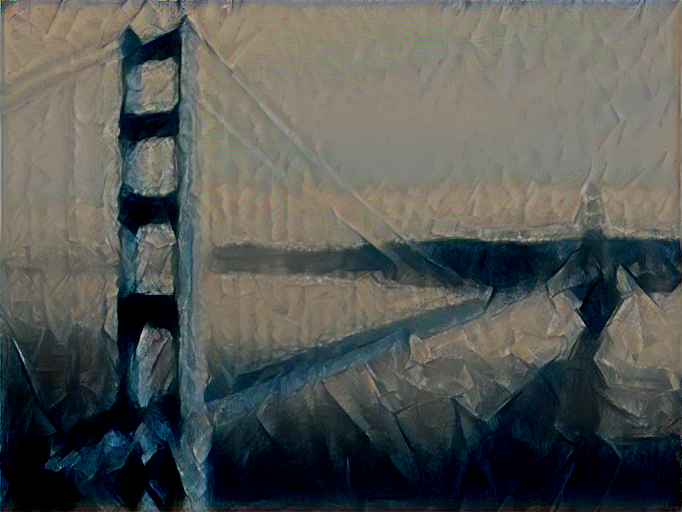

In [15]:
# display result
res = tens2pil(generated_img)
res

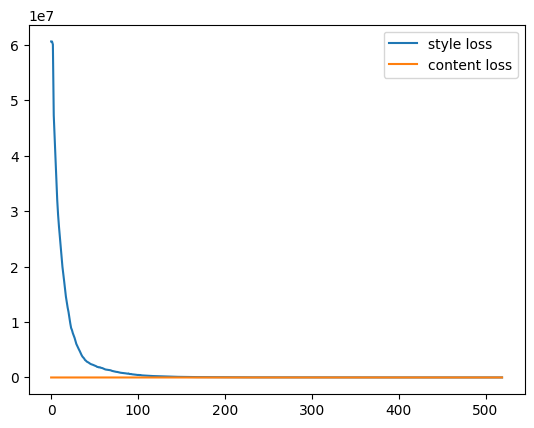

: 

In [16]:
plt.plot( catStyle.hist, label = 'style loss')
plt.plot( catContent.hist, label = 'content loss')
plt.legend()
plt.show()